In [2348]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
#from prophet import Prophet

In [2349]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [2350]:
#df = df[df['Mnd'] > '2024-01-01']

In [2351]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [2352]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [2353]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [2354]:
df

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-01-31,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,0.0
2008-02-29,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0
2008-03-31,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
2008-04-30,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
2008-05-31,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-10-31,19.9,23.4,20.3,8.8,5.8,3.3,5.5,3.5,5.9,3.7
2024-11-30,18.7,22.4,22.0,9.0,6.6,3.1,5.1,3.4,5.9,3.8
2024-12-31,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5


In [2355]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.7801822589557765, p-value: 0.39034408610867655
Hoyre ADF Statistic: -2.2989231540603043, p-value: 0.17231551097951114
Frp ADF Statistic: -1.582571861819359, p-value: 0.49234205741872633
SV ADF Statistic: -1.160916983088228, p-value: 0.6901783573567423
Sp ADF Statistic: -1.6059394874788055, p-value: 0.48060925134060084
KrF ADF Statistic: -1.8947928921859223, p-value: 0.33451464977124046
Venstre ADF Statistic: -2.8586375025689597, p-value: 0.05037365394503086
MDG ADF Statistic: -1.6159866377465042, p-value: 0.47483396704156744
Rodt ADF Statistic: -0.6134683727205307, p-value: 0.8679095925971021
Andre ADF Statistic: -1.7235826457432835, p-value: 0.4190047711122682


In [2356]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [2357]:
df_diff

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-02-29,-0.3,0.1,1.3,-0.7,-0.2,-0.1,0.1,0.0,0.0,0.0
2008-03-31,-0.3,0.8,0.0,0.3,-0.3,-0.2,-0.3,0.0,-0.2,0.0
2008-04-30,0.3,-1.2,0.2,-0.5,-0.1,0.9,0.5,0.0,0.1,0.0
2008-05-31,-0.1,0.9,0.5,0.2,0.2,-0.8,-0.6,0.0,0.2,0.0
2008-06-30,-2.9,-0.2,3.0,0.2,-0.4,-0.1,-0.3,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-10-31,-0.7,-1.2,1.4,-0.2,-0.2,0.4,0.4,0.2,0.3,-0.2
2024-11-30,-1.2,-1.0,1.7,0.2,0.8,-0.2,-0.4,-0.1,0.0,0.1
2024-12-31,-1.5,-1.2,3.4,0.4,-1.3,0.8,0.2,-0.3,-0.1,-0.3


In [2358]:
# ADF test on each column of df_diff
for col in df_diff.columns:
    result = adfuller(df_diff[col])
    print(f'{col}: p-value={result[1]}')

Ap: p-value=2.190660509485432e-19
Hoyre: p-value=1.4521498128779044e-11
Frp: p-value=5.315407770750361e-25
SV: p-value=2.8982918708725965e-22
Sp: p-value=5.076933478958635e-28
KrF: p-value=5.600375947842685e-25
Venstre: p-value=9.836451838517387e-26
MDG: p-value=9.368030291352459e-29
Rodt: p-value=1.5148471030925746e-13
Andre: p-value=1.31063897913123e-29


In [2359]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
model_fitted = model.fit(maxlags=12,method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
#print(model_fitted.summary())
model_fitted.k_ar

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


12

In [2360]:
from sklearn.metrics import r2_score

# Compute R² for each party
r2_scores = {}
for party in df_diff.columns:
    r2_scores[party] = r2_score(df_diff[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")


R² for Ap: 0.6350
R² for Hoyre: 0.6389
R² for Frp: 0.6772
R² for SV: 0.6537
R² for Sp: 0.6910
R² for KrF: 0.7243
R² for Venstre: 0.6599
R² for MDG: 0.6127
R² for Rodt: 0.6939
R² for Andre: 0.7430


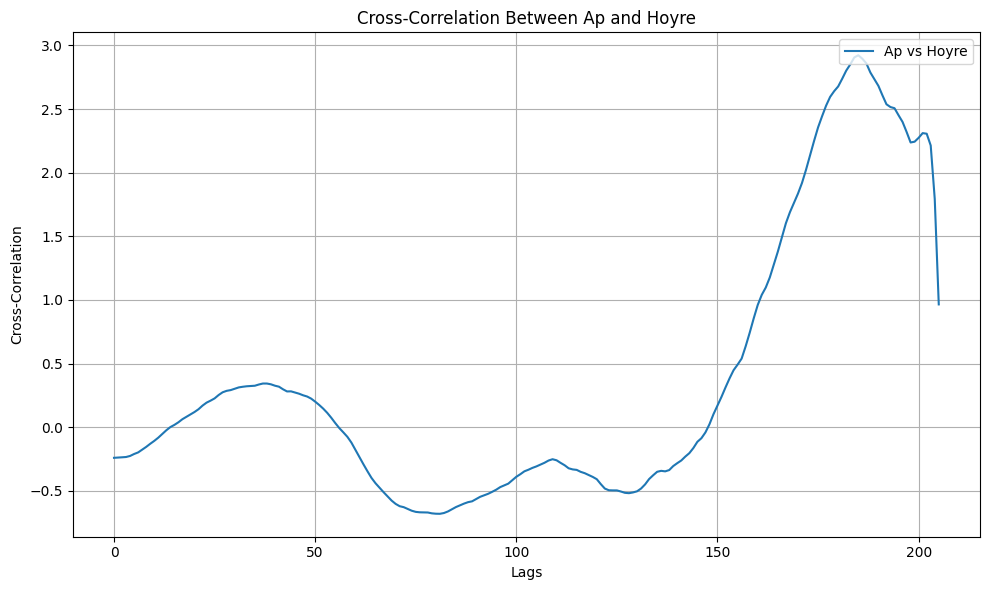

In [2390]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Define the parties to compare
party1 = 'Ap'
party2 = 'Hoyre'

# Compute cross-correlation between the two parties' time series
cross_corr = ccf(df[party1], df[party2])  # Calculate cross-correlation

# Plot the cross-correlation for the first 10 lags
plt.figure(figsize=(10, 6))
plt.plot(range(len(cross_corr)), cross_corr, label=f'{party1} vs {party2}')

# Add titles and labels
plt.title(f'Cross-Correlation Between {party1} and {party2}')
plt.xlabel('Lags')
plt.ylabel('Cross-Correlation')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


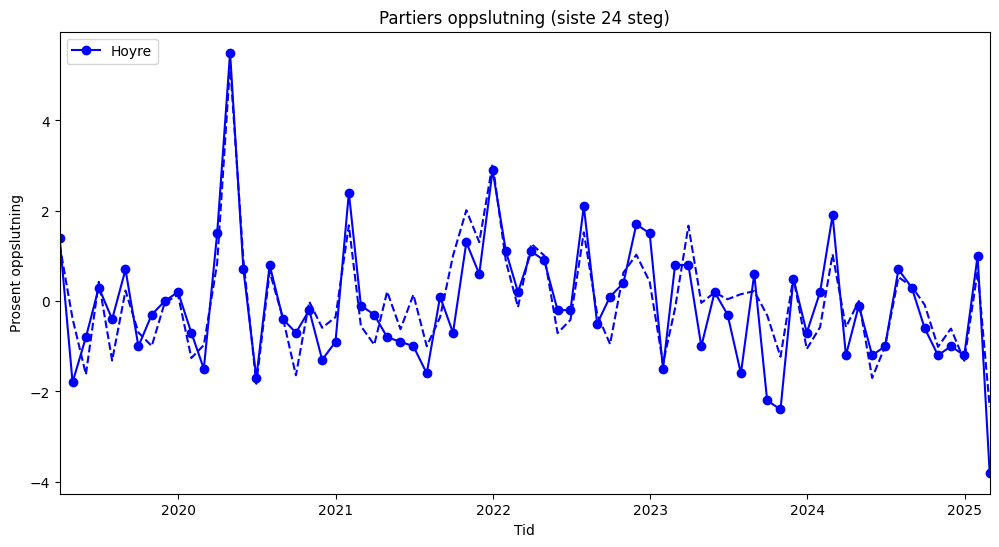

In [2361]:
steps = 72  # Number of time steps to plot back in time

# Get fitted values (predicted changes in differenced scale)
fitted_values = model_fitted.fittedvalues[-steps:]

# Define a color map for consistency
colors = {
#    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
#    'Frp': '#00008B',       # Dark Blue
#    'SV': '#FF6347',        # Light Red (Tomato)
#    'Sp': '#006400',        # Dark Green
#    'KrF': '#FFD700',       # Yellow (Gold)
#    'Venstre': '#ADD8E6',   # Light Blue
#    'MDG': '#008000',       # Green
#    'Rodt': '#8B0000',      # Dark Red
#    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]

    # Plot actual data (last 24 points)
    plt.plot(df_diff.index[-steps:], df_diff[party].iloc[-steps:], marker="o", color=color, label=f"{party}")

    # Plot fitted values (original scale)
    plt.plot(fitted_values.index, fitted_values[party], linestyle="dashed", color=color)


plt.xlim(df.index[-steps], df.index[-1])  # Set x-axis range to last 24 records
#plt.ylim(0, 40)  # Set y-axis limit
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("Partiers oppslutning (siste 24 steg)")
plt.legend(loc="upper left")
plt.show()


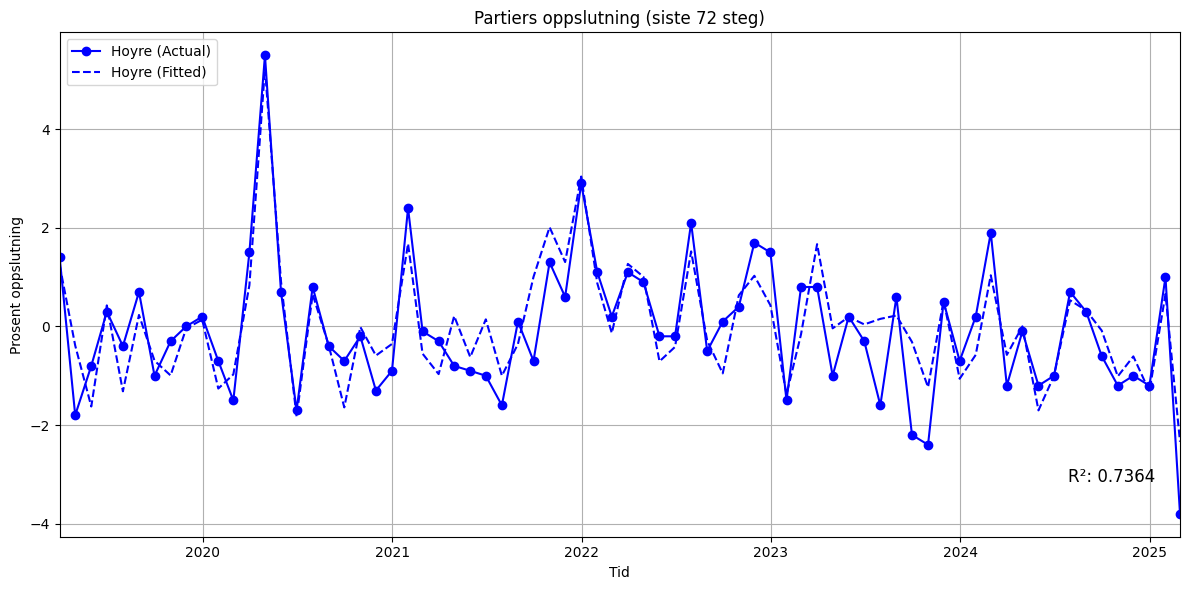

In [2391]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define a color map for consistency
colors = {
    'Hoyre': '#0000FF',  # Blue
}

# Number of time steps to plot back in time
steps = 72

# Get fitted values (predicted changes in differenced scale)
fitted_values = model_fitted.fittedvalues[-steps:]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]

    # Extract actual data for the last 'steps' data points
    actual_data = df_diff[party].iloc[-steps:]
    
    # Plot actual data (last 'steps' points)
    plt.plot(df_diff.index[-steps:], actual_data, marker="o", color=color, label=f"{party} (Actual)")

    # Plot fitted values (dashed line)
    plt.plot(fitted_values.index, fitted_values[party], linestyle="dashed", color=color, label=f"{party} (Fitted)")

    # Calculate the R-squared value between actual and fitted values
    r2 = r2_score(actual_data, fitted_values[party])

    # Print the R-squared value on the plot
    plt.text(0.9, 0.1, f"R²: {r2:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.xlim(df.index[-steps], df.index[-1])  # Set x-axis range to last 'steps' records
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("Partiers oppslutning (siste 72 steg)")

# Show the legend
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [2362]:
res1=model_fitted.test_normality(0.1)
print(res1)

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 10% significance level. Test statistic: 36.308, critical value: 28.412>, p-value: 0.014>


In [2363]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


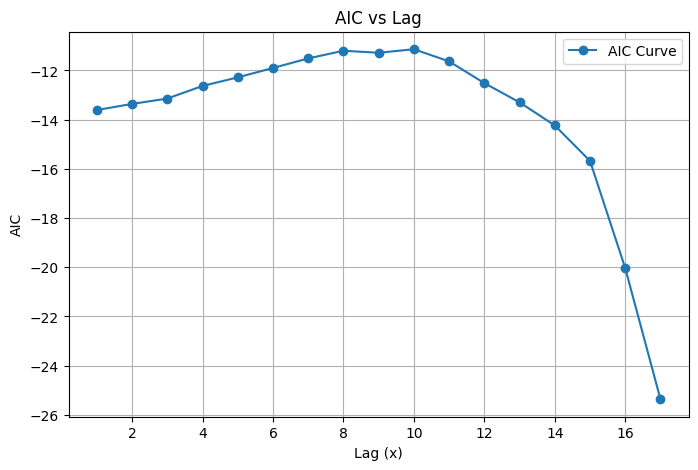

In [2364]:

# Example data from your loop
x = np.arange(1, 18)  # Lag values
aic = []  # Store AIC values

for lag in x:
    testmodel_fitted = model.fit(lag, method='ols', trend='n', verbose=True)
    aic.append(testmodel_fitted.aic)

# Convert lists to numpy arrays (optional)
x = np.array(x)
aic = np.array(aic)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, aic, marker='o', linestyle='-', label="AIC Curve")  # Line plot with dots
plt.xlabel("Lag (x)")
plt.ylabel("AIC")
plt.title("AIC vs Lag")
plt.legend()
plt.grid(True)
plt.show()


In [2365]:
steps = 7  # Number of steps to forecast
alpha = 0.5

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-03-31", periods=steps, freq='ME')

forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


In [2366]:
forecast_dates

DatetimeIndex(['2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
               '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', freq='ME')

In [2367]:
# Get forecast covariance in differenced scale
forecast_cov_diff = model_fitted.forecast_cov(steps=steps)

# Initialize original scale covariance matrix
forecast_cov_original_scale = np.zeros_like(forecast_cov_diff)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov_original_scale[t] = np.sum(forecast_cov_diff[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_original_df = {t: pd.DataFrame(forecast_cov_original_scale[t], index=df.columns, columns=df.columns)
                            for t in range(steps)}


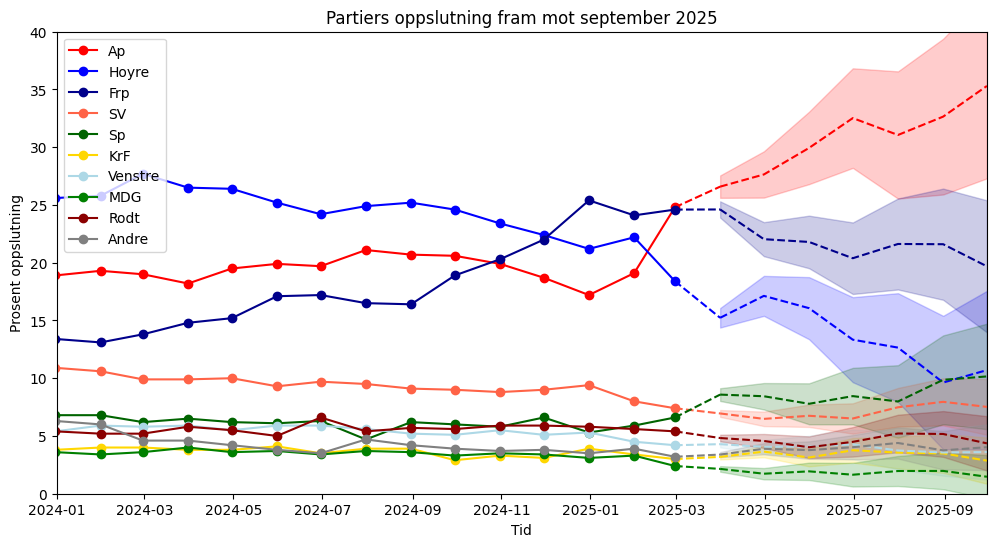

In [2368]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    last_actual_date = df.index[-1]
    first_forecast_date = forecast_original_scale.index[0]
    last_actual_value = df[party].iloc[-1]
    first_forecast_value = forecast_original_scale[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)

plt.xlim(np.datetime64("2024-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("Partiers oppslutning fram mot september 2025")
plt.legend(loc="upper left")
plt.show()

In [2369]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,26.586978,15.230567,24.611674,6.949367,8.581910,3.188812,4.290534,2.148595,4.822087,3.390940
2025-04-30,27.641337,17.130083,22.038654,6.480607,8.439560,3.645826,4.053595,1.732622,4.568508,3.891502
2025-05-31,29.938637,16.064626,21.798369,6.747370,7.785940,3.137705,4.087709,1.937112,4.024836,3.774431
2025-06-30,32.521807,13.336523,20.388873,6.513505,8.451059,3.763795,4.271070,1.644669,4.491024,4.028135
2025-07-31,31.060036,12.650511,21.622948,7.484824,7.985754,3.560158,3.743225,1.965599,5.215401,4.392699
2025-08-31,32.649736,9.626427,21.602332,7.955540,9.861469,3.489948,3.569568,1.975168,5.172993,3.755154
2025-09-30,35.305043,10.701684,19.687933,7.518807,10.155400,2.864493,3.608744,1.470352,4.361602,4.029192


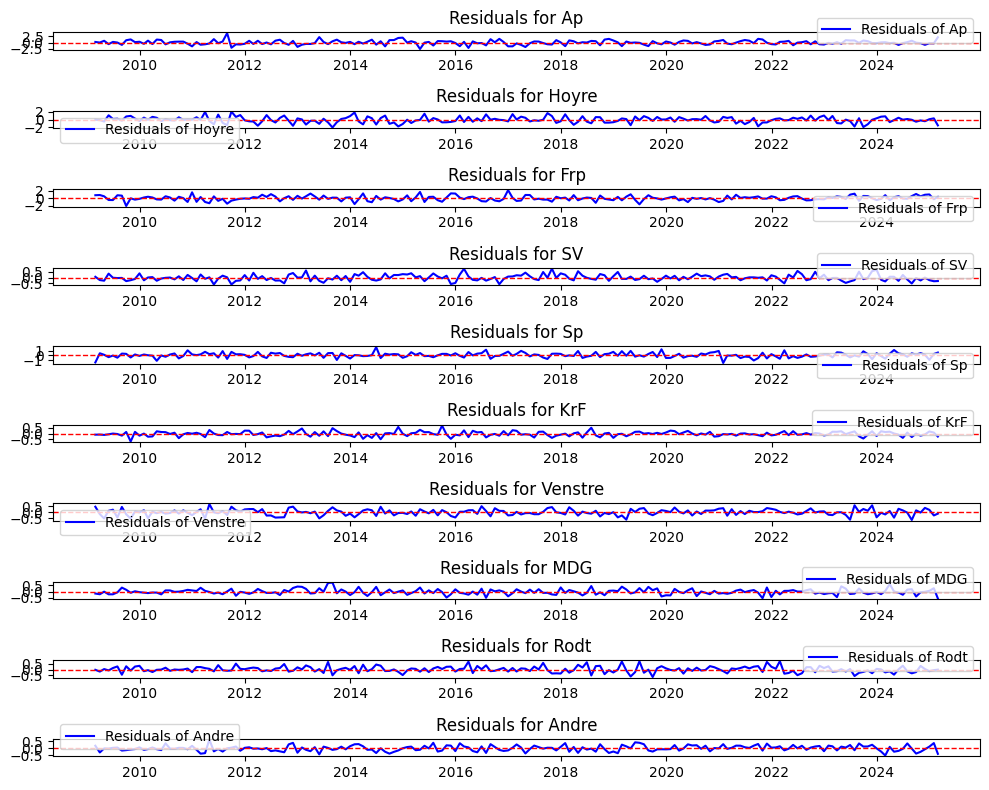

In [2370]:

# Get residuals from the fitted model
residuals = model_fitted.resid  # Residuals for all variables

# Plot residuals for each variable
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 8))

for i, col in enumerate(residuals.columns):
    axes[i].plot(residuals.index, residuals[col], label=f"Residuals of {col}", color="blue")
    axes[i].axhline(y=0, linestyle="--", color="red", linewidth=1)
    axes[i].set_title(f"Residuals for {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

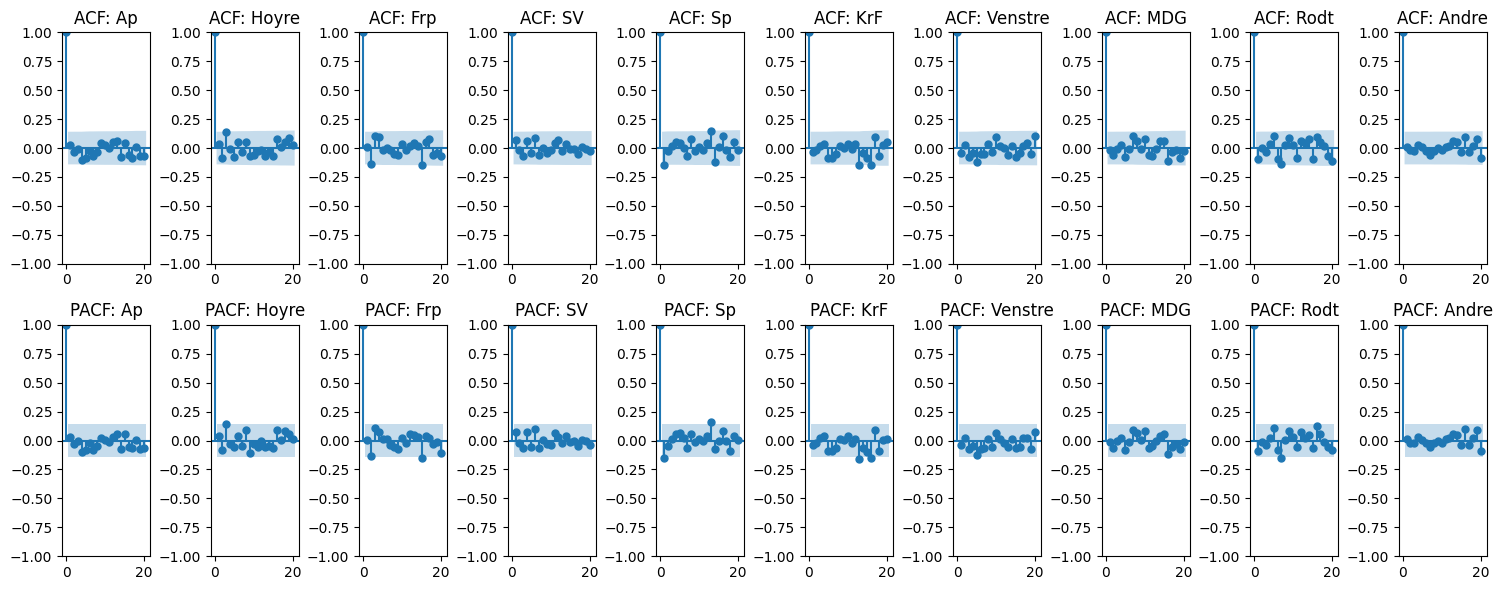

In [2371]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF for residuals of the first variable
fig, axes = plt.subplots(nrows=2, ncols=residuals.shape[1], figsize=(15, 6))

for i, col in enumerate(residuals.columns):
    plot_acf(residuals[col], ax=axes[0, i], lags=20, title=f"ACF: {col}")
    plot_pacf(residuals[col], ax=axes[1, i], lags=20, title=f"PACF: {col}")

plt.tight_layout()
plt.show()

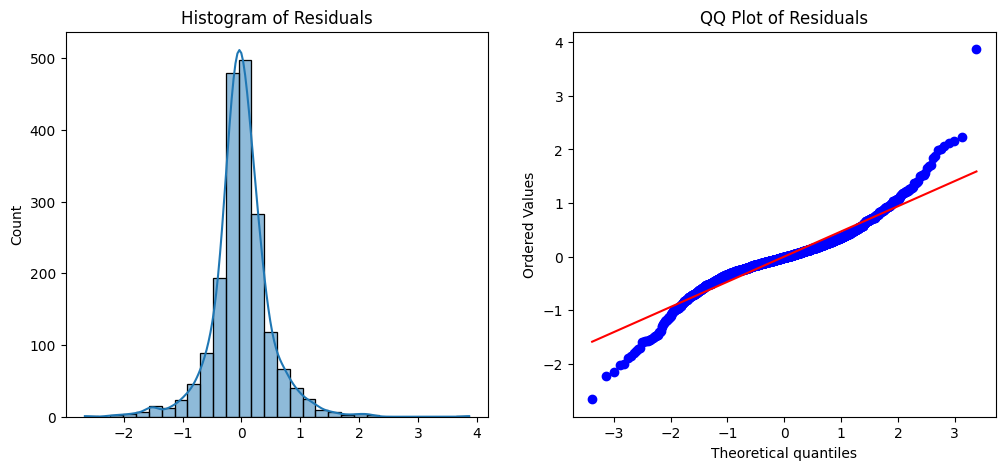

In [2372]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histogram of residuals
sns.histplot(residuals.values.flatten(), kde=True, ax=axes[0], bins=30)
axes[0].set_title("Histogram of Residuals")

# QQ Plot
stats.probplot(residuals.values.flatten(), dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot of Residuals")

plt.show()


In [2373]:
forecast_lower_original_scale


,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,25.617630,14.386755,23.908471,6.652453,8.030355,2.964226,4.012765,1.907647,4.535519,3.166518
2025-04-30,25.636511,15.399544,20.565649,5.855125,7.295909,3.154462,3.455059,1.242878,3.962761,3.408461
2025-05-31,26.802846,13.376521,19.522657,5.780770,6.011802,2.370699,3.152646,1.183896,3.085094,3.018361
2025-06-30,28.209701,9.656556,17.292828,5.200727,6.004729,2.698657,2.990820,0.623146,3.214289,2.978803
2025-07-31,25.553085,7.938664,17.683143,5.813442,4.845098,2.190123,2.108747,0.665435,3.591530,3.042602
2025-08-31,25.906811,3.851673,16.787610,5.914790,6.016009,1.807234,1.563804,0.390266,3.190948,2.095670
2025-09-30,27.305540,3.840632,13.973597,5.105597,5.587275,0.861883,1.221436,-0.407702,2.008386,2.043878


In [2374]:
forecast_upper_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,27.556326,16.074379,25.314877,7.246281,9.133465,3.413398,4.568304,2.389543,5.108655,3.615362
2025-04-30,29.646163,18.860621,23.511659,7.106088,9.583211,4.137191,4.652131,2.222365,5.174255,4.374543
2025-05-31,33.074429,18.752731,24.074081,7.713969,9.560079,3.904710,5.022773,2.690328,4.964579,4.530501
2025-06-30,36.833913,17.016491,23.484917,7.826283,10.897388,4.828933,5.551320,2.666192,5.767760,5.077467
2025-07-31,36.566986,17.362359,25.562753,9.156207,11.126410,4.930193,5.377703,3.265762,6.839271,5.742797
2025-08-31,39.392661,15.401181,26.417054,9.996291,13.706929,5.172663,5.575332,3.560069,7.155039,5.414639
2025-09-30,43.304546,17.562735,25.402270,9.932017,14.723525,4.867104,5.996052,3.348406,6.714817,6.014506


In [2375]:
# Example: Your existing dataframes (assuming they have the same index and columns)
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_original_scale.loc[date_to_extract]
lower_row = forecast_lower_original_scale.loc[date_to_extract]
upper_row = forecast_upper_original_scale.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)


     Party   Estimate      Lower      Upper
0       Ap  35.305043  27.305540  43.304546
1    Hoyre  10.701684   3.840632  17.562735
2      Frp  19.687933  13.973597  25.402270
3       SV   7.518807   5.105597   9.932017
4       Sp  10.155400   5.587275  14.723525
5      KrF   2.864493   0.861883   4.867104
6  Venstre   3.608744   1.221436   5.996052
7      MDG   1.470352  -0.407702   3.348406
8     Rodt   4.361602   2.008386   6.714817
9    Andre   4.029192   2.043878   6.014506


In [2376]:
# Antall simuleringar
n_sim = 10000

# Trekke stemmer frå normalfordeling
red_green_votes = np.zeros(n_sim)
blue_votes = np.zeros(n_sim)

# Iterate over the result_df DataFrame
for _, row in result_df.iterrows():
    party = row["Party"]
    yhat = row["Estimate"]
    lower = row["Lower"]
    upper = row["Upper"]

    z_alpha_half = norm.ppf(1 - (1 - alpha) / 2)  # Compute Z-score for given alpha
    factor = 2 * z_alpha_half  # Convert to full interval width
    #print(factor)
    std_dev = (upper - lower) / factor  # Omformar intervall til standardavvik (~50% dekking)
    samples = np.random.normal(yhat, std_dev, n_sim)
    
    if party in ["Ap", "SV", "Sp", "Rodt", "MDG"]:
        red_green_votes += samples
    else:
        blue_votes += samples

# Sannsyn for at den raudgrøne blokka er større
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.8052


In [2377]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,26.586978,15.230567,24.611674,6.949367,8.581910,3.188812,4.290534,2.148595,4.822087,3.390940
2025-04-30,27.641337,17.130083,22.038654,6.480607,8.439560,3.645826,4.053595,1.732622,4.568508,3.891502
2025-05-31,29.938637,16.064626,21.798369,6.747370,7.785940,3.137705,4.087709,1.937112,4.024836,3.774431
2025-06-30,32.521807,13.336523,20.388873,6.513505,8.451059,3.763795,4.271070,1.644669,4.491024,4.028135
2025-07-31,31.060036,12.650511,21.622948,7.484824,7.985754,3.560158,3.743225,1.965599,5.215401,4.392699
2025-08-31,32.649736,9.626427,21.602332,7.955540,9.861469,3.489948,3.569568,1.975168,5.172993,3.755154
2025-09-30,35.305043,10.701684,19.687933,7.518807,10.155400,2.864493,3.608744,1.470352,4.361602,4.029192


In [2378]:
# Number of simulations
n_sim = 100000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov_original_scale[0]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 1.0000


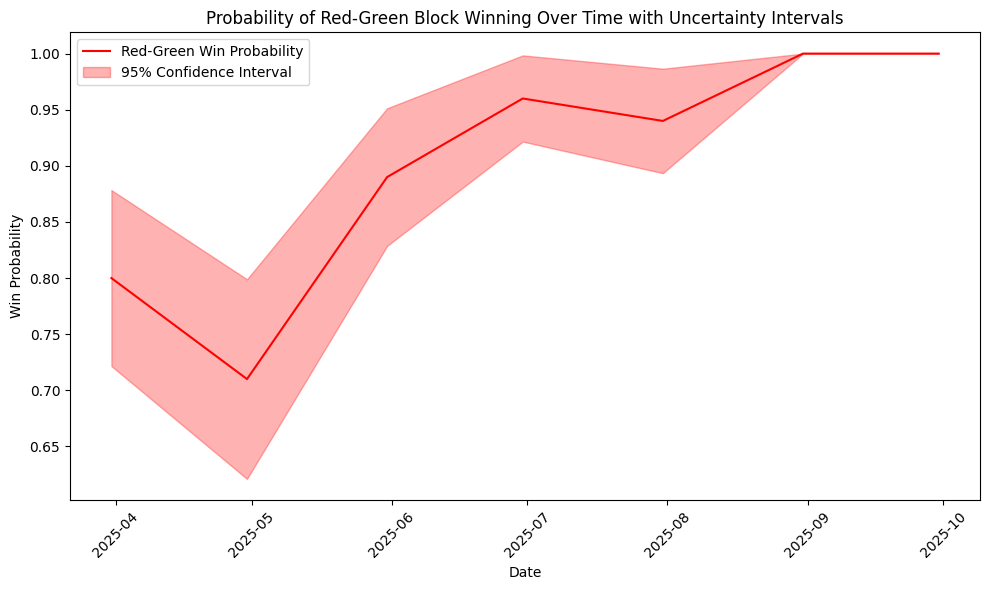

In [2379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Number of simulations
n_sim = 100

# Party groupings for Red-Green and Blue blocks
red_green_parties = ["Ap", "SV", "Sp", "Rodt", "MDG"]
blue_parties = ["Hoyre", "Frp", "KrF", "Venstre"]

# Create empty lists to store results over time
prob_red_green_wins_over_time = []
lower_bound_over_time = []
upper_bound_over_time = []

# Loop over each forecast step (time period)
for step in range(len(forecast_original_scale)):
    # Extract mean estimates (yhat) and covariance matrix for the current time step
    yhat_vector = forecast_original_scale.iloc[step].values  # Mean estimates for all parties
    cov_matrix = forecast_cov_original_scale[step]  # Covariance matrix at the current step

    # Generate correlated samples using the multivariate normal distribution
    samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)

    # Create a DataFrame with sampled values
    sampled_df = pd.DataFrame(samples, columns=['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre'])

    # Compute vote totals for each simulation
    red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
    blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

    # Compute win probability as the proportion of red-green wins
    win_indicator = (red_green_votes > blue_votes).astype(int)  # 1 if red-green block wins, 0 if not

    # Calculate the binomial confidence interval using binom.interval
    p_hat = np.mean(win_indicator)  # Proportion of wins
    lower_bound, upper_bound = stats.binom.interval(0.95, np.sqrt(n_sim), p_hat)  # 95% confidence interval

    mu = p_hat * n_sim  # mean
    sigma = np.sqrt(n_sim * p_hat * (1 - p_hat))  # standard deviation
    z_alpha_half = stats.norm.ppf(1 - 0.025)  # 1.96 for a 95% confidence level

    # Compute lower and upper bounds using the normal approximation
    lower_bound = mu - z_alpha_half * sigma
    upper_bound = mu + z_alpha_half * sigma

    # Normalize the bounds to proportions
    lower_bound = lower_bound / n_sim
    upper_bound = upper_bound / n_sim

    # Store the results
    prob_red_green_wins_over_time.append(p_hat)
    lower_bound_over_time.append(lower_bound)
    upper_bound_over_time.append(upper_bound)

# Create a DataFrame to hold the probabilities over time
forecast_dates = forecast_original_scale.index
prob_red_green_wins_df = pd.DataFrame({
    "Red-Green Win Probability": prob_red_green_wins_over_time,
    "Lower Bound (95%)": lower_bound_over_time,
    "Upper Bound (95%)": upper_bound_over_time
}, index=forecast_dates)

# Plot the probability of red-green block winning with uncertainty intervals
plt.figure(figsize=(10, 6))
plt.plot(prob_red_green_wins_df.index, prob_red_green_wins_df["Red-Green Win Probability"], label="Red-Green Win Probability", color="red")
plt.fill_between(prob_red_green_wins_df.index, prob_red_green_wins_df["Lower Bound (95%)"], prob_red_green_wins_df["Upper Bound (95%)"], 
                 color='red', alpha=0.3, label="95% Confidence Interval")
plt.title("Probability of Red-Green Block Winning Over Time with Uncertainty Intervals")
plt.xlabel("Date")
plt.ylabel("Win Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


In [2380]:
lower_bound_over_time

[0.7216014406183979,
 0.6210642720173203,
 0.8286747345259758,
 0.9215927065891575,
 0.8934534343385949,
 1.0,
 1.0]

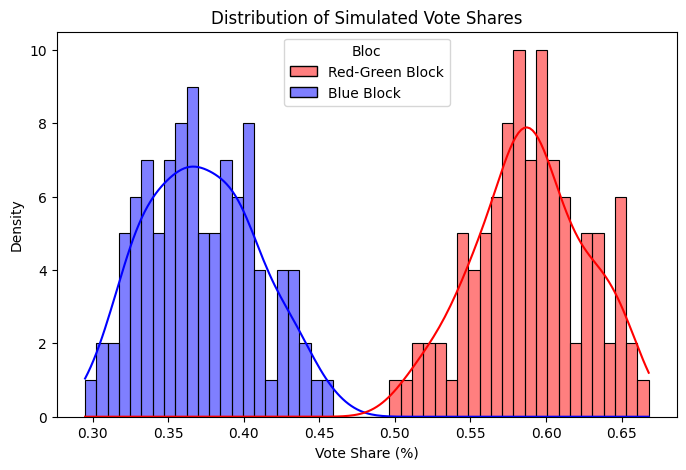

In [2381]:

# Create a DataFrame with both red-green and blue votes
df_votes = pd.DataFrame({
    "Red-Green Block": red_green_votes,
    "Blue Block": blue_votes
})

# Melt the DataFrame for easier plotting
df_votes_melted = df_votes.melt(var_name="Bloc", value_name="Votes")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(data=df_votes_melted, x="Votes", hue="Bloc", kde=True, palette={"Red-Green Block": "red", "Blue Block": "blue"}, alpha=0.5, bins=50)
plt.xlabel("Vote Share (%)")
plt.ylabel("Density")
plt.title("Distribution of Simulated Vote Shares")
plt.show()


In [2382]:
yhat_vector

array([35.30504271, 10.7016838 , 19.68793331,  7.51880711, 10.15539968,
        2.86449332,  3.60874376,  1.47035185,  4.36160175,  4.02919186])

In [2383]:
cov_matrix

array([[20.24222131, -8.78738024, -3.88175333, -1.50454514, -2.19213018,
        -0.23086771, -0.86911174, -0.50052011, -1.5907325 , -0.07207996],
       [-8.78738024, 14.88914859, -3.13356785, -0.15817768, -1.9558336 ,
        -0.71557198, -0.31305687, -0.52714802,  0.69409823, -0.12872119],
       [-3.88175333, -3.13356785, 10.31153079, -0.10243728, -0.68246882,
        -0.3890739 , -0.96230419, -0.0624755 , -0.63924133, -0.36490539],
       [-1.50454514, -0.15817768, -0.10243728,  1.83777654, -0.53255562,
         0.14102861,  0.11405942, -0.11620961, -0.1210831 ,  0.31408329],
       [-2.19213018, -1.9558336 , -0.68246882, -0.53255562,  6.60582047,
        -0.40711042, -0.04494041,  0.08719306,  0.26835917, -1.21109791],
       [-0.23086771, -0.71557198, -0.3890739 ,  0.14102861, -0.40711042,
         1.27388077,  0.1334802 ,  0.22496684, -0.14835855,  0.1852435 ],
       [-0.86911174, -0.31305687, -0.96230419,  0.11405942, -0.04494041,
         0.1334802 ,  1.80543514, -0.09915699

<Axes: >

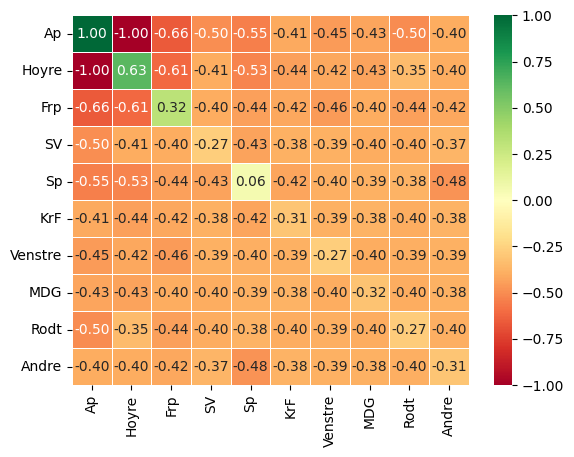

In [2384]:

#cov_divided=cov_matrix/yhat_vector

matrix_min = cov_matrix.min()
matrix_max = cov_matrix.max()

normalized_matrix = 2 * (cov_matrix - matrix_min) / (matrix_max - matrix_min) - 1


# Plot heatmap
sns.heatmap(normalized_matrix, 
            annot=True,        # Show values inside the heatmap
            cmap="RdYlGn",
            fmt=".2f",         # Format values to 2 decimal places
            linewidths=0.5,    # Grid lines
            xticklabels=['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre'],  # Ensure party names on X-axis
            yticklabels=['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre'])    # Ensure party names on Y-axis


In [2385]:
# Define party groupings
red_green_parties = ["Ap", "SV", "Sp", "Rodt", "MDG"]
blue_parties = ["Hoyre", "Frp", "KrF", "Venstre"]

# Calculate sum columns for each bloc
forecast_original_scale["Red-Green Block"] = forecast_original_scale[red_green_parties].sum(axis=1)
forecast_lower_original_scale["Red-Green Block"] = forecast_lower_original_scale[red_green_parties].sum(axis=1)
forecast_upper_original_scale["Red-Green Block"] = forecast_upper_original_scale[red_green_parties].sum(axis=1)

forecast_original_scale["Blue Block"] = forecast_original_scale[blue_parties].sum(axis=1)
forecast_lower_original_scale["Blue Block"] = forecast_lower_original_scale[blue_parties].sum(axis=1)
forecast_upper_original_scale["Blue Block"] = forecast_upper_original_scale[blue_parties].sum(axis=1)


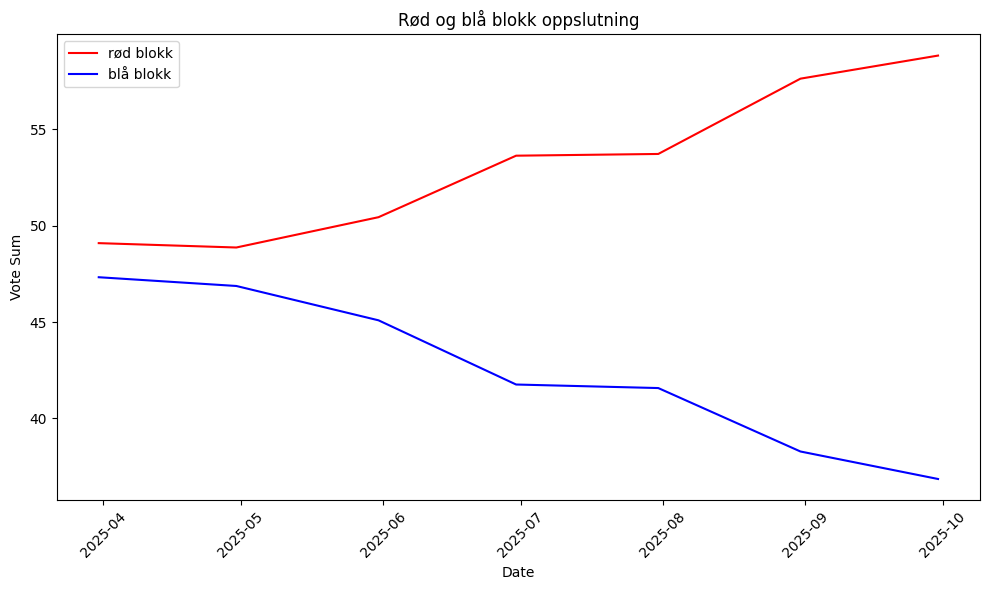

In [2386]:
# Plot the red-green and blue block time series
plt.figure(figsize=(10, 6))

# Plot Red-Green Block
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Red-Green Block", label="rød blokk", color="red")

# Plot Blue Block
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Blue Block", label="blå blokk", color="blue")

# Customize the plot
plt.title('Rød og blå blokk oppslutning')
plt.xlabel('Date')
plt.ylabel('Vote Sum')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


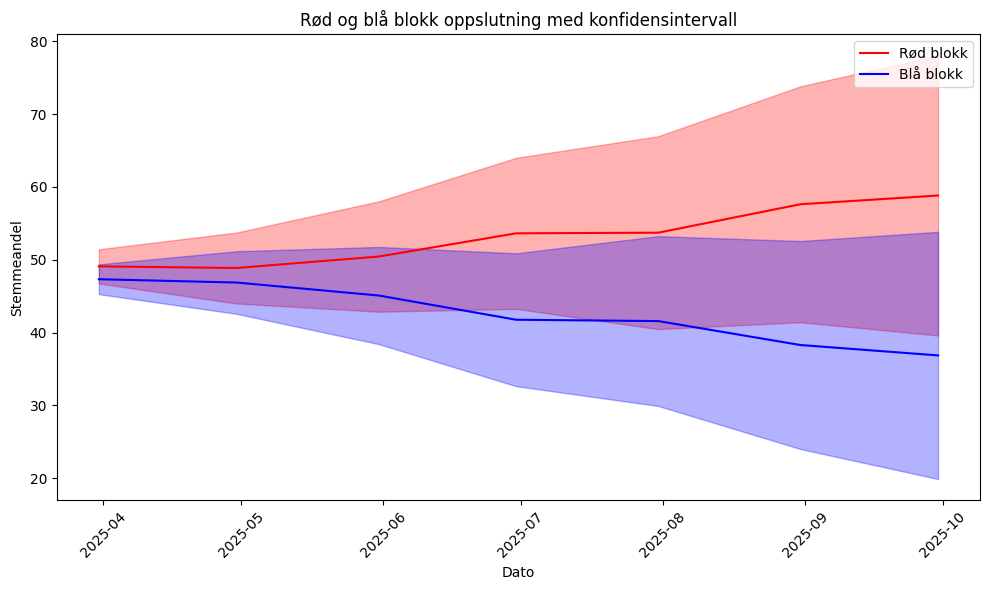

In [2387]:
# Plot the red-green and blue block time series with confidence intervals
plt.figure(figsize=(10, 6))

# Plot Red-Green Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Red-Green Block", label="Rød blokk", color="red")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Red-Green Block"], 
                 forecast_upper_original_scale["Red-Green Block"], 
                 color="red", alpha=0.3)

# Plot Blue Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Blue Block", label="Blå blokk", color="blue")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Blue Block"], 
                 forecast_upper_original_scale["Blue Block"], 
                 color="blue", alpha=0.3)

# Customize the plot
plt.title('Rød og blå blokk oppslutning med konfidensintervall')
plt.xlabel('Dato')
plt.ylabel('Stemmeandel')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
